In [122]:
%load_ext autoreload
%autoreload 2
!source /home/murilo/RelNetCare/.env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


11027.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [123]:
from datasets import Dataset, DatasetDict
import os
import json
import torch
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_cap = -1
set_data = None
dataset_sets = {}
dict_sets = {}
data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART"
data_stem = data_folder.split('/')[-1]
base_model = 'facebook/bart-large'
model_path = f"/mnt/vdb1/murilo/models/fine-tuned/{base_model}/{data_stem}"

args_dict = {
    'memorization_task': False,
    'merge_train_dev': False
}


for set_ in ('train', 'test', 'dev'):

    data_path = os.path.join(data_folder, f'{set_}.json')

    with open(data_path, 'r') as f:
        data = json.load(f)
            
    # Remap keys and separate into train/test
    if args_dict['memorization_task']:
        if not set_data:
            set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data[data_cap:]]
    else:
        set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data]
        
    # Merge 'train' and 'dev' if the flag is set
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            dict_sets['train'] = dict_sets['train'] + set_data
        else:
           dict_sets[set_] = set_data
    else:
        dict_sets[set_] = set_data
        

    
for set_ in ('train', 'test', 'dev'):
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            continue
    set_data = dict_sets[set_]
    dataset_sets[set_] = Dataset.from_dict(
        {"text": [item["text"] for item in set_data],
         "summary": [item["summary"] for item in set_data],
         "title": [item["title"] for item in set_data]}
        )
    

# Create DatasetDict
dataset_dict = DatasetDict(dataset_sets)
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 2304
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 841
    })
    dev: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 705
    })
})

In [127]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

# Specify your directory path

all_folders = [f for f in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, f))]

# If there's only one folder, set it as the checkpoint folder
if len(all_folders) == 1:
    checkpoint_folder = all_folders[0]
    full_checkpoint_path = os.path.join(model_path, checkpoint_folder)
    print(full_checkpoint_path)
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(full_checkpoint_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(full_checkpoint_path).to(device)
else:
    raise Exception("More than one checkpoint found. Be more specific!")

# Initialize an empty list to store raw_predicted_labels
raw_predicted_labels = []

# Loop through the test set
for entry in tqdm(dataset_dict['test']):
    text = entry['text']
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model.generate(inputs, max_length=100, do_sample=False)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    raw_predicted_labels.append(summary)

# Confirm the shape
assert len(raw_predicted_labels) == len(dataset_dict['test'])


/mnt/vdb1/murilo/models/fine-tuned/facebook/bart-large/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/checkpoint-864


100%|██████████| 841/841 [05:28<00:00,  2.56it/s]


In [128]:
raw_predicted_labels[:10]

['Speaker 1 has visited Montauk. Speaker 5 is a parent of Speaker 7. Speaker 7 is a child of Speaker 1.',
 'Speaker 2 is a parent of Speaker 1. Speaker 1 is a child of Speaker 2.',
 "Speaker 2 is a sibling of Speaker 1. Speaker 1 is other family of Phoebe. Frank's spouse is Speaker 2. Frank is a parent of Speaker 3. Speaker 3 is a child of Frank.",
 'Speaker 3 is a parent of Speaker 1. Speaker 1 is a child of Speaker 3.',
 'Speaker 1 is a parent of Speaker 4. Speaker 4 is a child of Speaker 1.',
 'Speaker 1 is a parent of Speaker 4. Speaker 4 is a child of Speaker 1.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 1 is a parent of Speaker 4. Speaker 4 is a child of Speaker 1.',
 'Speaker 1 is a parent of Speaker 4. Speaker 4 is a child of Speaker 1.',
 '']

In [129]:
from src.processing.bart_processing import RelationConverter
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def convert_raw_labels_to_relations(raw_predicted_labels, input_path=''):
    converter = RelationConverter(input_path=input_path)
    predicted_labels = []

    for raw_label in tqdm(raw_predicted_labels):
        label_relations = []
        if raw_label:
            for sent in sent_tokenize(raw_label): 
                try:
                    sub, rel, obj = converter._convert_sentence_to_relation(sent[:-1] if sent.endswith('.') else sent)
                except Exception as e:
                    print(f'Exception `{e}` with sentence below:\n`{sent}`')
                    sub, rel, obj = ("ERROR", "ERROR", "ERROR")
                label_relations.append({'subject': sub, 'relation': rel, 'object': obj})

        predicted_labels.append(label_relations)

    # Confirm the shape
    assert len(raw_predicted_labels) == len(predicted_labels)
    return predicted_labels

# Usage
predicted_labels = convert_raw_labels_to_relations(raw_predicted_labels)
predicted_labels[:3]

[nltk_data] Downloading package punkt to /home/murilo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initialized with input path: 
Output path set to         : -prepBART


100%|██████████| 841/841 [00:00<00:00, 12116.56it/s]

Exception `not enough values to unpack (expected 3, got 2)` with sentence below:
`Speaker 3's spouses is Speaker 2.`
Exception `not enough values to unpack (expected 3, got 1)` with sentence below:
`Speaker 1's spouse has been Speaker 3.`
Exception `not enough values to unpack (expected 3, got 1)` with sentence below:
`Speaker 1 has a spouse like Speaker 3.`
Exception `not enough values to unpack (expected 3, got 1)` with sentence below:
`Barbara's spouse has been Speaker 1.`
Exception `not enough values to unpack (expected 3, got 2)` with sentence below:
`Barbara has spouse is Speaker 4.`
Exception `not enough values to unpack (expected 3, got 2)` with sentence below:
`Barbara has spouse is Speaker 1.`
Exception `not enough values to unpack (expected 3, got 1)` with sentence below:
`Speaker 1's spouse has spouse like Speaker 2.`
Exception `not enough values to unpack (expected 3, got 1)` with sentence below:
`Speaker 1's spouse has spouse Speaker 2.`
Exception `not enough values to un

[[{'subject': 'Speaker 1', 'relation': 'visited_place', 'object': 'Montauk'},
  {'subject': 'Speaker 5', 'relation': 'parents', 'object': 'Speaker 7'},
  {'subject': 'Speaker 7', 'relation': 'children', 'object': 'Speaker 1'}],
 [{'subject': 'Speaker 2', 'relation': 'parents', 'object': 'Speaker 1'},
  {'subject': 'Speaker 1', 'relation': 'children', 'object': 'Speaker 2'}],
 [{'subject': 'Speaker 2', 'relation': 'siblings', 'object': 'Speaker 1'},
  {'subject': 'Speaker 1', 'relation': 'other_family', 'object': 'Phoebe'},
  {'subject': 'Frank', 'relation': 'spouse', 'object': 'Speaker 2'},
  {'subject': 'Frank', 'relation': 'parents', 'object': 'Speaker 3'},
  {'subject': 'Speaker 3', 'relation': 'children', 'object': 'Frank'}]]

In [130]:
true_labels = convert_raw_labels_to_relations(dataset_dict['test']['summary'])


Initialized with input path: 
Output path set to         : -prepBART


100%|██████████| 841/841 [00:00<00:00, 10898.94it/s]


In [131]:
RelationExtractorEvaluator()
df = evaluator.assess_performance_on_lists(
    true_labels_list=true_labels, pred_labels_list=predicted_labels, return_details=True,
    output_path='/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/bart-base'
    )
df


Script successfully executed!
# INFERENCE REPORT
/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/bart-base_20231003_135418.xlsx



,id,prompt,raw_inference,true_labels,predicted_labels,correct_labels,wrong_labels,missing_labels,dialogue,f1s,precision,recall,error_message
0,1,,None,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Montauk"",\n ""relation"": ...",None,0.0,0.0,0.0,
1,2,,None,[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],None,0.0,0.0,0.0,
2,3,,None,[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],None,0.0,0.0,0.0,
3,4,,None,[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],None,0.0,0.0,0.0,
4,5,,None,[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",[],None,0.0,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,837,,None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""California"",\n ""relation...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",None,0.0,0.0,0.0,
837,838,,None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],[],None,1.0,1.0,1.0,
838,839,,None,"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",None,0.0,0.0,0.0,
839,840,,None,"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",None,0.0,0.0,0.0,


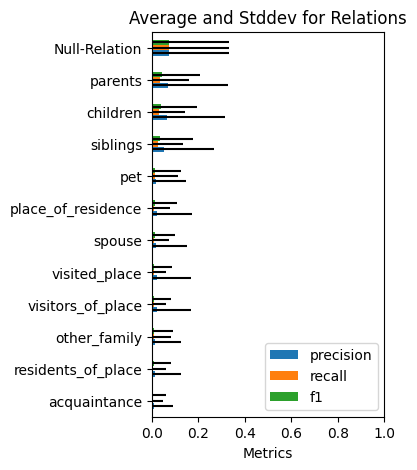

In [132]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics

# children/parents/siblings/spouse/visited_place
# Define your ontology
your_ontology = {
    "Null-Relation", 
    "visited_place",  "visitors_of_place", "residents_of_place", "place_of_residence",
    "siblings", "spouse", "children", "parents",  "other_family", "pet", "acquaintance", 
    # "Attachment"
    # "title", "alternate_names", "place_of_work", "unanswerable"
    }

# your_ontology = list(config.allowed_relations)

# your_ontology = config.all_relations
# Usage
my_metrics = RelationGranularMetrics(df, your_ontology)
result = my_metrics.process()
chart_df = my_metrics.to_dataframe()
my_metrics.plot_metrics(chart_df, figsize=(3,5))
# my_metrics.plot_metrics(chart_df, figsize=(4,12))


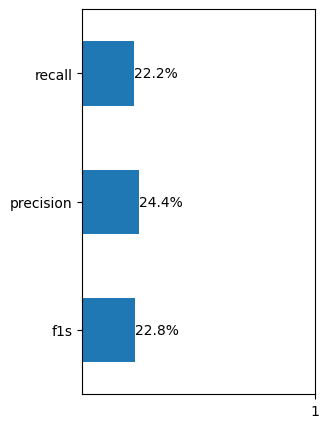

In [133]:
import matplotlib.pyplot as plt

# Your plotting code here
ax = df[['f1s', 'precision', 'recall']].mean().plot(kind='barh', alpha=1, figsize=(3, 5))

# Set x-axis tick labels
plt.xticks([1], ['1'])

# Adding data values on top of each bar
for bar in ax.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1%}', 
             va='center', ha='left')

# Show the plot
plt.show()
